# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
df = pd.read_csv('Datafiles/heart - heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
df.duplicated().sum()

0

No duplicates, no null values. Lets take a look at the object data types and see if we have any inconsistent values

In [5]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [6]:
df.describe(include = ['object'])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


I'm going to change Sex to IsMale and ExerciseAngina to a binary column

In [7]:
df['Sex'] = df['Sex'].map({'M':1,'F':0})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y':1,'N':0})
df.rename(columns = {'Sex':'IsMale'}, inplace = True)
df.head()

,Age,IsMale,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195,0,Normal,122,0,0.0,Up,0


In [8]:
df['ST_Slope'].value_counts()

Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64

In [9]:
df['ChestPainType'].value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [10]:
df['RestingECG'].value_counts()

Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64

In [15]:
df['HeartDisease'].value_counts(normalize = True)

1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   IsMale          918 non-null    int64  
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 86.2+ KB


I'll leave the rest of the columns as is for now, lets create the preprocessors

# Preprocessing

In [12]:
# Scaler and OHE
scaler = StandardScaler()
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

# Column Selectors
num_cols = make_column_selector(dtype_include = 'number')
cat_cols = make_column_selector(dtype_include = 'object')

# Tuples
num_tuple = (scaler, num_cols)
cat_tuple = (ohe, cat_cols)

# Transformer
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')

In [14]:
preproc = preprocessor.fit_transform(df)
preproc

array([[-1.4331398 ,  0.51595242,  0.41090889, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47848359, -1.93816322,  1.49175234, ...,  0.        ,
         1.        ,  0.        ],
       [-1.75135854,  0.51595242, -0.12951283, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.37009972,  0.51595242, -0.12951283, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.37009972, -1.93816322, -0.12951283, ...,  0.        ,
         1.        ,  0.        ],
       [-1.64528563,  0.51595242,  0.30282455, ...,  0.        ,
         0.        ,  1.        ]])

Looks good. Lets split our data and transform the features

# Validation Split

In [17]:
X = df.drop(columns = ['HeartDisease'])
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(688, 11)
(230, 11)
(688,)
(230,)


11 columns in our feature matrix. Lets preprocess them

In [20]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

In [21]:
X_train

array([[ 0.23929215,  0.5370191 ,  1.1838018 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.23929215,  0.5370191 ,  1.1838018 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.55896789,  0.5370191 ,  0.91381054, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.66552646,  0.5370191 , -0.16615451, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66552646,  0.5370191 ,  1.02180704, ...,  0.        ,
         0.        ,  1.        ],
       [-1.46564508, -1.86213116,  0.91381054, ...,  0.        ,
         1.        ,  0.        ]])

Now that we have our processed validation split, lets start composing our neural network with Keras

# Composing Neural Net

In [22]:
# Defining our input shape
input_shape = X_train.shape[1]
input_shape

18

In [24]:
# Creating the instance of the model
model = Sequential()

# First layer: Input Layer
model.add(Dense(18, input_dim = input_shape, activation = 'relu'))

# Second Layer for fun
model.add(Dense(10, activation = 'relu'))

# Output Layer
model.add(Dense(1, activation = 'sigmoid'))

# Compiling
model.compile(optimizer = 'adam', loss = 'bce')

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 18)                342       
                                                                 
 dense_4 (Dense)             (None, 10)                190       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 543
Trainable params: 543
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), 
                    epochs = 200)

Epoch 1/200
22/22 [==============================] - 0s 8ms/step - loss: 0.6971 - val_loss: 0.6547
Epoch 2/200
22/22 [==============================] - 0s 2ms/step - loss: 0.6364 - val_loss: 0.5971
Epoch 3/200
22/22 [==============================] - 0s 2ms/step - loss: 0.5807 - val_loss: 0.5433
Epoch 4/200
22/22 [==============================] - 0s 2ms/step - loss: 0.5299 - val_loss: 0.4877
Epoch 5/200
22/22 [==============================] - 0s 2ms/step - loss: 0.4827 - val_loss: 0.4391
Epoch 6/200
22/22 [==============================] - 0s 2ms/step - loss: 0.4450 - val_loss: 0.4074
Epoch 7/200
22/22 [==============================] - 0s 2ms/step - loss: 0.4193 - val_loss: 0.3851
Epoch 8/200
22/22 [==============================] - 0s 2ms/step - loss: 0.4002 - val_loss: 0.3714
Epoch 9/200
22/22 [==============================] - 0s 2ms/step - loss: 0.3880 - val_loss: 0.3634
Epoch 10/200
22/22 [==============================] - 0s 2ms/step - loss: 0.3779 - val_loss: 0.3537
Epoch 11/

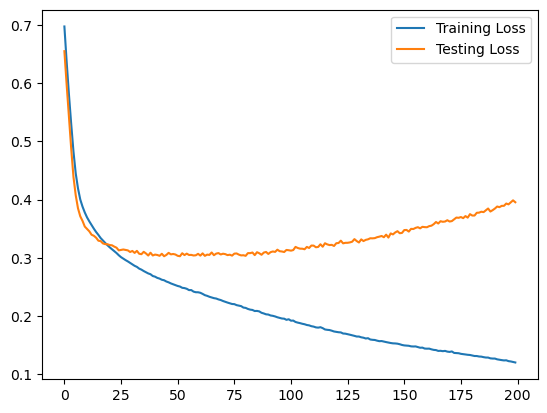

In [28]:
# Visualizing the loss
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Testing Loss')
plt.legend()
plt.show();

This first model overfit. I'll create a second model with less neurons to see if it reduces the fit

In [32]:
model2 = Sequential()
model2.add(Dense(8, input_dim = input_shape, activation = 'relu'))
model2.add(Dense(4, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))
model2.compile(optimizer = 'adam', loss = 'bce')

In [35]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 152       
                                                                 
 dense_7 (Dense)             (None, 4)                 36        
                                                                 
 dense_8 (Dense)             (None, 1)                 5         
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [33]:
hist2 = model2.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 200)

Epoch 1/200
22/22 [==============================] - 0s 7ms/step - loss: 0.6375 - val_loss: 0.6173
Epoch 2/200
22/22 [==============================] - 0s 2ms/step - loss: 0.6094 - val_loss: 0.5890
Epoch 3/200
22/22 [==============================] - 0s 2ms/step - loss: 0.5847 - val_loss: 0.5651
Epoch 4/200
22/22 [==============================] - 0s 2ms/step - loss: 0.5629 - val_loss: 0.5448
Epoch 5/200
22/22 [==============================] - 0s 2ms/step - loss: 0.5445 - val_loss: 0.5276
Epoch 6/200
22/22 [==============================] - 0s 2ms/step - loss: 0.5283 - val_loss: 0.5128
Epoch 7/200
22/22 [==============================] - 0s 2ms/step - loss: 0.5131 - val_loss: 0.4994
Epoch 8/200
22/22 [==============================] - 0s 2ms/step - loss: 0.4948 - val_loss: 0.4774
Epoch 9/200
22/22 [==============================] - 0s 2ms/step - loss: 0.4714 - val_loss: 0.4542
Epoch 10/200
22/22 [==============================] - 0s 2ms/step - loss: 0.4458 - val_loss: 0.4299
Epoch 11/

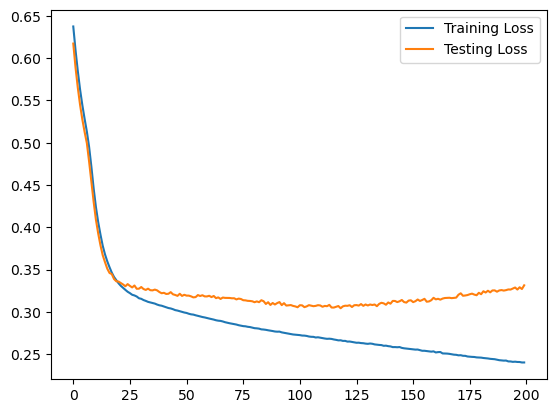

In [34]:
# Visualizing the loss
plt.plot(hist2.history['loss'], label = 'Training Loss')
plt.plot(hist2.history['val_loss'], label = 'Testing Loss')
plt.legend()
plt.show();

This model isn't overfit, but it isnt producing as good of a result on either the test or training data. lets try one more

In [36]:
model3 = Sequential()
model3.add(Dense(18, input_dim = input_shape, activation = 'relu'))
model3.add(Dense(8, activation = 'relu'))
model3.add(Dense(4, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))
model3.compile(loss = 'bce', optimizer = 'adam')

In [37]:
hist3 = model3.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 200)

Epoch 1/200
22/22 [==============================] - 0s 8ms/step - loss: 0.7232 - val_loss: 0.6708
Epoch 2/200
22/22 [==============================] - 0s 2ms/step - loss: 0.6244 - val_loss: 0.5958
Epoch 3/200
22/22 [==============================] - 0s 2ms/step - loss: 0.5496 - val_loss: 0.5283
Epoch 4/200
22/22 [==============================] - 0s 2ms/step - loss: 0.4859 - val_loss: 0.4695
Epoch 5/200
22/22 [==============================] - 0s 2ms/step - loss: 0.4353 - val_loss: 0.4244
Epoch 6/200
22/22 [==============================] - 0s 2ms/step - loss: 0.3985 - val_loss: 0.3944
Epoch 7/200
22/22 [==============================] - 0s 2ms/step - loss: 0.3734 - val_loss: 0.3712
Epoch 8/200
22/22 [==============================] - 0s 2ms/step - loss: 0.3564 - val_loss: 0.3611
Epoch 9/200
22/22 [==============================] - 0s 2ms/step - loss: 0.3465 - val_loss: 0.3518
Epoch 10/200
22/22 [==============================] - 0s 2ms/step - loss: 0.3380 - val_loss: 0.3492
Epoch 11/

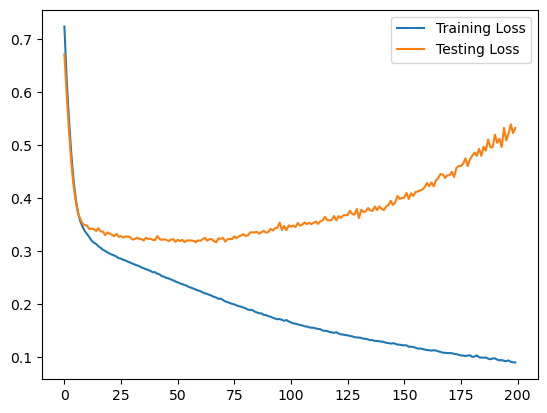

In [38]:
# Visualizing the loss
plt.plot(hist3.history['loss'], label = 'Training Loss')
plt.plot(hist3.history['val_loss'], label = 'Testing Loss')
plt.legend()
plt.show();

Performance got worse on this model. The best model was the first one. 